# Neural Network

## Load Data

In [1]:
from timeit import default_timer as timer
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import helper
import numpy as np
import tensorflow as tf

In [2]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'
tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 7:
Image - Min Value: 17 Max Value: 221
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


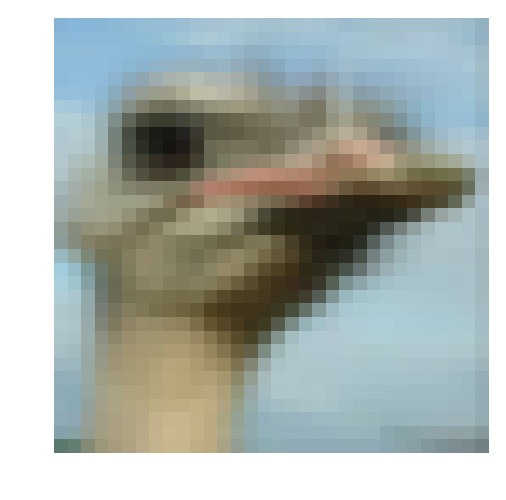

In [3]:
# Explore the dataset
batch_id = 4
sample_id = 7
batch_size = 5
image_sizes = 32
image_channels = 3
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [4]:
def normalize(x):
    x_min = np.min(x)
    return (x - x_min)/(np.max(x) - x_min)

def one_hot_encode(x):
    encoder = tf.one_hot(x, 10)
    encodings = None
    with tf.Session() as sess:
        encodings = sess.run(encoder)
    return encodings

In [235]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

## Check Point

In [5]:
import pickle
import helper

# Load the Preprocessed Validation data for cifar-10
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build Netwrok

In [6]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

In [7]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(x * alpha, x)

def selu(x):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    tmp1 = scale * tf.nn.elu(x)
    tmp2 = scale * alpha * (tf.nn.elu(-1*tf.nn.relu(-1*x)))
    return tmp1 + tmp2

In [8]:
def filter_weights_initializer(arr, dtype=tf.float32):
    return arr

In [9]:
class Network(object):
    
    def __init__(self, x_dim, x_channels, n_classes, 
                 p_f1_w, p_f1_w_shape, 
                 p_f2_w, p_f2_w_shape, 
                 p_fc_w, p_fc_b):
        # Inputs
        self.p_f1_w = p_f1_w
        self.p_f1_w_shape = p_f1_w_shape
        self.p_f2_w = p_f2_w
        self.p_f2_w_shape = p_f2_w_shape
        self.p_fc_w = p_fc_w
        self.p_fc_b = p_fc_b
        self.init_placeholders(x_dim, x_channels, n_classes)
        # Model
        self.logits = self.build()
        self.prediction = tf.nn.softmax(self.logits)
        # Loss and Optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=self.logits, 
            labels=self.y))
        self.optimizer = tf.train.AdamOptimizer().minimize(self.cost)
        # Accuracy
        correct_pred = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.prediction, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

    def init_placeholders(self, x_dim, x_channels, n_classes):
        self.x = tf.placeholder(tf.float32, [None, x_dim, x_dim, x_channels], name='x')
        self.y = tf.placeholder(tf.int64, [None, n_classes], name='y')
        
        filter1_w_ = np.reshape(self.p_f1_w, self.p_f1_w_shape)
        self.filter1_w = tf.Variable(filter1_w_, dtype=tf.float32)
        filter2_w_ = np.reshape(self.p_f2_w, self.p_f2_w_shape)
        self.filter2_w = tf.Variable(filter2_w_, dtype=tf.float32)
        
        self.fc_w = tf.Variable(self.p_fc_w, dtype=tf.float32, name='fc_w')
        self.fc_b = tf.Variable(self.p_fc_b, dtype=tf.float32, name='fc_b')

    def build(self):
        conv1 = tf.nn.conv2d(self.x, self.filter1_w, strides=(1, 1, 1, 1), padding='VALID')
        conv1_a = selu(conv1)
        conv2 = tf.nn.conv2d(conv1_a, self.filter2_w, strides=(1, 1, 1, 1), padding='VALID')
        conv2_a = selu(conv2)
        conv_flat = tf.contrib.layers.flatten(conv2_a)
        logits = tf.nn.bias_add(tf.matmul(conv_flat, self.fc_w), self.fc_b)
        return logits

In [10]:
def print_stats(session, net, total_epochs, epoch, batch_i, feature_batch, label_batch):
    train_loss = session.run(net.cost, feed_dict={net.x:feature_batch, net.y:label_batch})
    valid_loss = session.run(net.cost, feed_dict={net.x:valid_features, net.y:valid_labels})
    train_accuracy = session.run(net.accuracy, feed_dict={net.x:feature_batch, net.y:label_batch})
    valid_accuracy = session.run(net.accuracy, feed_dict={net.x:valid_features, net.y:valid_labels})
    print('Epoch {:>2}/{:>2}, CIFAR-10 Batch {} | Train Acc: {:1.2} Loss: {:1.3} | Valid Acc: {:1.2} Loss: {:1.3}'.format(
        epoch, total_epochs, batch_i, train_accuracy, train_loss, valid_accuracy, valid_loss), end='\r')

In [11]:
def truncated_normal(mean=0.0, stddev=0.1, minval=-1.0, maxval=1.0):
    return np.clip(np.random.normal(mean, stddev), minval, maxval)

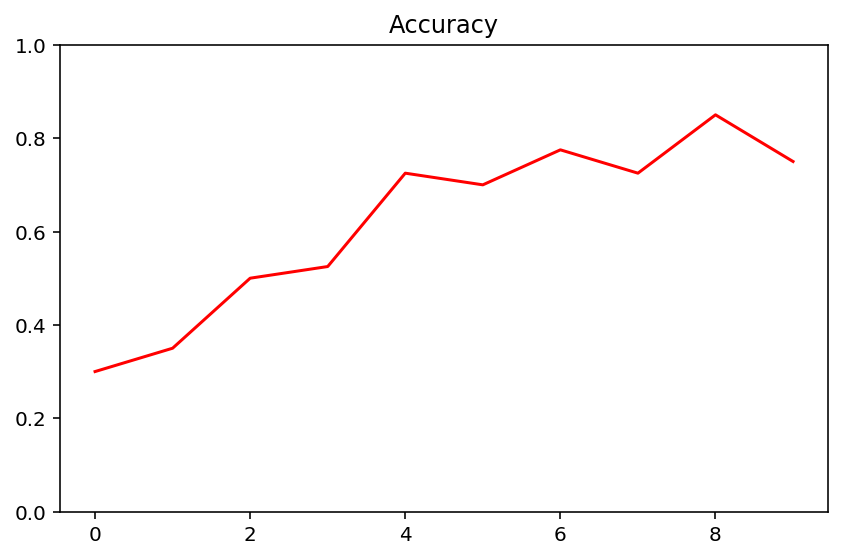

In [12]:
batch_size = 128
x_dim = 32
x_channels = 3
n_classes = 10
epochs = 10

tf.reset_default_graph()
with tf.Session() as sess:
    
    f1_depth = 64
    f1_filter = 3
    f1_dim = x_channels * f1_filter * f1_filter * f1_depth
    f1_shape = (f1_filter, f1_filter, x_channels, f1_depth)
    f1_w = np.array([truncated_normal() for _ in range(f1_dim)])
    
    f2_depth = 32
    f2_filter = 3
    f2_dim = f1_depth * f2_filter * f2_filter * f2_depth
    f2_shape = (f2_filter, f2_filter, f1_depth, f2_depth)
    f2_w = np.array([truncated_normal() for _ in range(f2_dim)])
    
    fc_w = np.array([[truncated_normal() for _ in range(n_classes)] for _ in range(25088)]) #TODO find out dimension
    fc_b = np.zeros(n_classes)

    net = Network(x_dim, x_channels, n_classes, 
                  f1_w, f1_shape, 
                  f2_w, f2_shape,
                  fc_w, fc_b)
    sess.run(tf.global_variables_initializer())
    accuracies = []
    # Initializing the variables
    for e in range(epochs):
        n_batches = 1
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                # Run optimizers
                feed_dict = {net.x:batch_features,
                             net.y:batch_labels}
                _ = sess.run([net.optimizer], feed_dict=feed_dict)
                logits, predict, accuracy = sess.run([net.logits, net.prediction, net.accuracy], feed_dict=feed_dict)

        accuracies.append(accuracy)

    acc_plot = plt.subplot(111)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(range(epochs), accuracies, 'r', label='Accuracy')
    acc_plot.set_ylim([0, 1.0])
    plt.tight_layout()
    plt.show()

# Genetic Algorithm

In [13]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm

from operator import attrgetter
import string
import random
import time

In [14]:
__DEBUG__ = False
batch_size = 128
x_dim = 32
x_channels = 3
n_classes = 10
epochs = 20

In [15]:
class Individual(object):
    
    def __init__(self, generation):
        self.accuracy = -1
        self.generation = generation
        
        # layer 1 filter
        self.f1_depth = 64
        self.f1_filter = 3
        self.f1_dim = x_channels * self.f1_filter * self.f1_filter * self.f1_depth
        self.f1_shape = (self.f1_filter, self.f1_filter, x_channels, self.f1_depth)
        
        # layer 2 filter
        self.f2_depth = 32
        self.f2_filter = 3
        self.f2_dim = self.f1_depth * self.f2_filter * self.f2_filter * self.f2_depth
        self.f2_shape = (self.f2_filter, self.f2_filter, self.f1_depth, self.f2_depth)
        
    def generate(self):
        self.gene = {}
        
        # layer 1 filter
        self.gene[0] = np.array([truncated_normal() for _ in range(f1_dim)])

        # layer 2 filter
        self.gene[1] = np.array([truncated_normal() for _ in range(f2_dim)])

        # fc weights + bias
        self.gene[2] = np.array([[truncated_normal() for _ in range(n_classes)] for _ in range(25088)]) #TODO find out dimension
        self.gene[3] = np.random.randn(n_classes)
        
    def fitness(self):
        tf.reset_default_graph()
        with tf.Session() as sess:
            net = Network(x_dim, 
                          x_channels,
                          n_classes,
                          self.gene[0], self.f1_shape,
                          self.gene[1], self.f2_shape,
                          self.gene[2], 
                          self.gene[3])
            sess.run(tf.global_variables_initializer())
            
            values = []
            n_batches = 5
            for batch_i in range(1, n_batches + 1):
                for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                    feed_dict = {net.x: batch_features,
                                 net.y: batch_labels}
                    values += sess.run([net.accuracy], feed_dict=feed_dict)
            self.accuracy = np.mean(values)

    def cross_over(self, parent):
        # Complete Continuous Recombination
        child = {}
        for i, g in enumerate(self.gene):
            child[i] = parent.gene[i][:]
        
        for i, g in enumerate(child):
            child[i] = (child[i][:] + parent.gene[i][:])/2.
                    
        individ = Individual(generation=self.generation)
        individ.gene = child
        return individ
        
    def mutate(self, mutation_rate):
        for i, g in self.gene.items():
            for j, v in enumerate(g):
                prob = np.random.sample()
                if prob <= mutation_rate:
                    g[j] = truncated_normal()
            
    def backpropagation(self, backpropagation_momentum):
        prob = np.random.sample()
        if prob <= backpropagation_momentum:
            tf.reset_default_graph()
            with tf.Session() as sess:
                net = Network(x_dim, 
                              x_channels,
                              n_classes,
                              self.gene[0], self.f1_shape,
                              self.gene[1], self.f2_shape,
                              self.gene[2], 
                              self.gene[3])
                sess.run(tf.global_variables_initializer())

                n_batches = 5
                for batch_i in range(1, n_batches + 1):
                    for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                        # Run optimizers
                        feed_dict = {net.x: batch_features,
                                     net.y: batch_labels}
                        _ = sess.run([net.optimizer], feed_dict=feed_dict)
                self.gene[0] = np.reshape(sess.run(net.filter1_w), (self.f1_dim))
                self.gene[1] = np.reshape(sess.run(net.filter2_w), (self.f2_dim))
                self.gene[2] = sess.run(net.fc_w)
                self.gene[3] = sess.run(net.fc_b)
        

In [16]:
class Population(object):
    
    def __init__(self,
                 initial_population=200, 
                 max_generations=1000,
                 mutation_rate=0.01, 
                 elitism=True,
                 tournament_size=4,
                 solution_threshold=.99,
                 backpropagation_momentum=.5):
        self.initial_population = initial_population
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.elitism = elitism
        self.tournament_size = tournament_size
        self.solution_threshold = solution_threshold
        self.backpropagation_momentum = backpropagation_momentum
        self.time_elapsed = 0.0
        self.global_best_individual = None
        self.global_best_solution = 0.0
        self.current_best_individual = None
        self.current_best_solution = 0.0
        self.generation = 0
        self.population = []

    def _evaluate_best_(self):
        self.current_best_individual = self._evaluate_current_best_individual_()
        self.current_best_solution = self.current_best_individual.accuracy
        if self.global_best_individual == None or self.global_best_solution < self.current_best_solution:
            self.global_best_individual = self.current_best_individual
            self.global_best_solution = self.current_best_solution

    def _perform_tournament_selection_(self):
        tournament = Population()
        tournament.generation = self.generation
        for _ in range(self.tournament_size):
            i = random.choice(self.population)
            tournament.add_individual(i)
        return tournament._evaluate_current_best_individual_()
    
    def _evaluate_current_best_individual_(self):
        return max(self.population, key=attrgetter('accuracy'))
    
    def evaluate_fitnesses(self):
        population_length = len(self.population)
        for i, p in enumerate(self.population):
            if p.accuracy < 0:
                p.fitness()
                print('{}/{}, Accuracy {}'.format(i+1, 
                                                  population_length, 
                                                  p.accuracy))
        self._evaluate_best_()
    
    def generate(self):
        assert self.initial_population > 0
        self.population = [Individual(generation=self.generation) for _ in range(self.initial_population)]
        for p in self.population:
            p.generate()
    
    def evolve_generation(self):
        children_genes = []
        self.evaluate_fitnesses()  
        
        if self.elitism:
            children_genes.append(self.current_best_individual)
            
        for _ in range(self.initial_population):
            # perform selection
            male = self._perform_tournament_selection_()
            female = self._perform_tournament_selection_()
            # perform cross-over
            new_individual = male.cross_over(female)
            new_individual.generation = self.generation
            # perform mutation
            new_individual.mutate(self.mutation_rate)
            # backpropagation
            new_individual.backpropagation(self.backpropagation_momentum)
            # insert individual
            children_genes.append(new_individual)
        
        self.population = children_genes
        self.generation += 1
    
    def found_solution(self):
        return self.global_best_solution >= self.solution_threshold
    
    def add_individual(self, individual):
        self.population.append(individual)
    
    def print_accuracy(self):
        if self.generation == 0:
            return
        print('Generation: {}/{}, Solution accuracy: {}'.format(
            self.generation, 
            self.max_generations,
            self.global_best_solution))    

In [29]:
# hypter-parameters
max_generations = 10
population_size = 20
mutation_rate = 0.05
backpropagation_momentum = 0.2

In [30]:
def execute(max_generations, population_size, mutation_rate, backpropagation_momentum, display_interval=1):
    population = Population(population_size, 
                            max_generations, 
                            mutation_rate=mutation_rate,
                            backpropagation_momentum=backpropagation_momentum)
    population.generate()
    accuracies = []
    while not population.found_solution() and population.generation < max_generations:
        population.evolve_generation()
        if population.generation % display_interval == 0:
            population.print_accuracy()
        accuracies.append(population.global_best_individual.accuracy)
    best_individual = population.global_best_individual
    print('\nCompleted {} generations:\nFinal accuracy: {}, Generation: {}'.format(
        population.generation, 
        best_individual.accuracy, 
        best_individual.generation))
    
    acc_plot = plt.subplot(111)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(range(len(accuracies)), accuracies, 'r', label='Accuracy')
    acc_plot.set_ylim([0, 1.0])
    plt.tight_layout()
    plt.show()
    
    return best_individual, population

1/20, Accuracy 0.10065141320228577
2/20, Accuracy 0.10096830874681473
3/20, Accuracy 0.141289621591568
4/20, Accuracy 0.10216989368200302
5/20, Accuracy 0.1003873273730278
6/20, Accuracy 0.10267604887485504
7/20, Accuracy 0.10002201050519943
8/20, Accuracy 0.08774207532405853
9/20, Accuracy 0.10501760244369507
10/20, Accuracy 0.0985739454627037
11/20, Accuracy 0.07823503762483597
12/20, Accuracy 0.08957306295633316
13/20, Accuracy 0.10022006928920746
14/20, Accuracy 0.0888996496796608
15/20, Accuracy 0.12468310445547104
16/20, Accuracy 0.09757482260465622
17/20, Accuracy 0.10694102197885513
18/20, Accuracy 0.10662411898374557
19/20, Accuracy 0.10743837803602219
20/20, Accuracy 0.10077905654907227
Generation: 1/10, Solution accuracy: 0.141289621591568
2/21, Accuracy 0.10724472254514694
3/21, Accuracy 0.0955105647444725
4/21, Accuracy 0.11711268126964569
5/21, Accuracy 0.08805897831916809
6/21, Accuracy 0.09450264275074005
7/21, Accuracy 0.11421215534210205
8/21, Accuracy 0.1233142688870

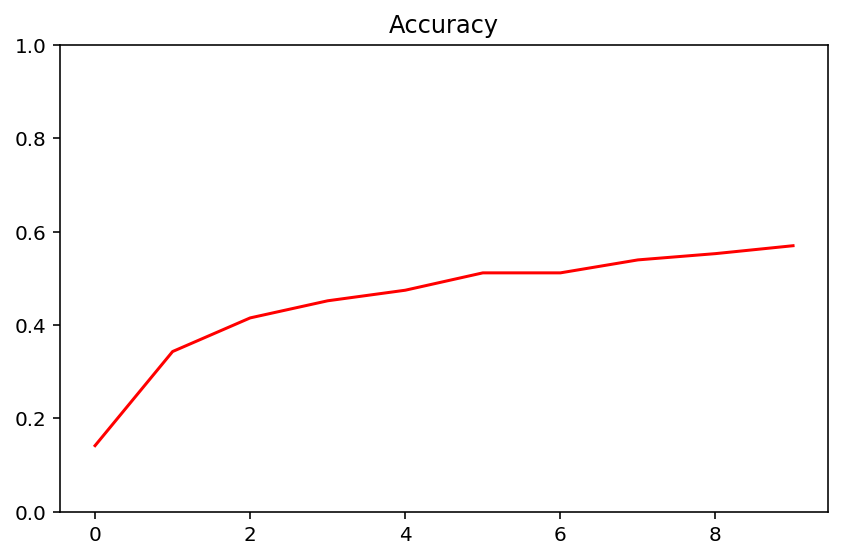

In [31]:
best_individ, population = execute(max_generations, population_size, mutation_rate, backpropagation_momentum)

## Test Model - MNIST

In [32]:
test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))

with tf.Session() as sess:
    net = Network(x_dim, 
                  x_channels,
                  n_classes,
                  best_individ.gene[0], best_individ.f1_shape,
                  best_individ.gene[1], best_individ.f2_shape,
                  best_individ.gene[2], 
                  best_individ.gene[3])
    sess.run(tf.global_variables_initializer())

    values = []
    for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
        # Run optimizers
        feed_dict = {net.x: test_feature_batch,
                     net.y: test_label_batch}
        values += sess.run([net.accuracy], feed_dict=feed_dict)
    accuracy = np.mean(values)
    print('Validation accuracy: ', accuracy)

Validation accuracy:  0.506032


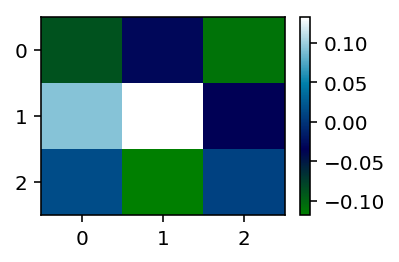

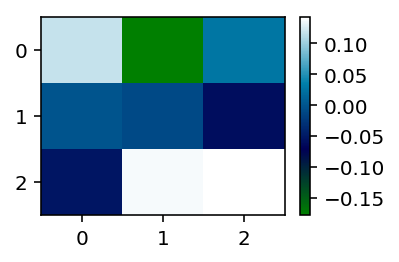

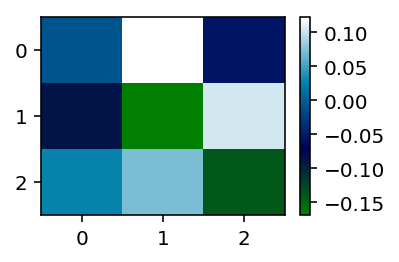

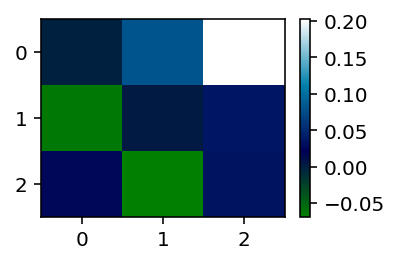

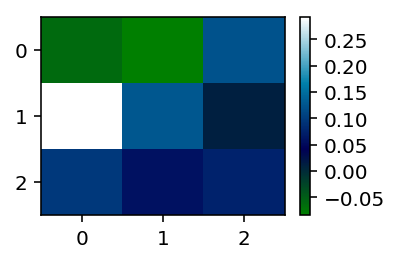

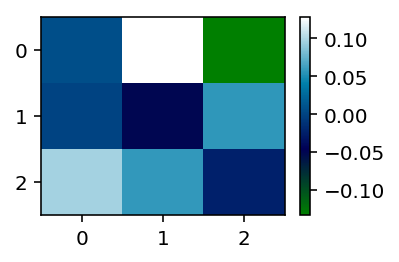

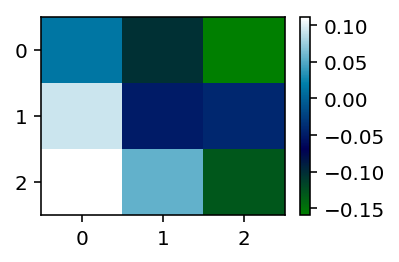

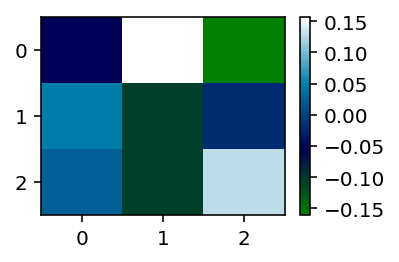

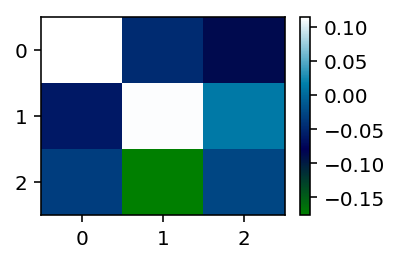

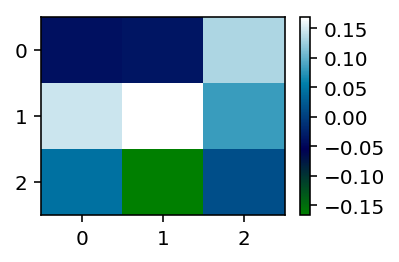

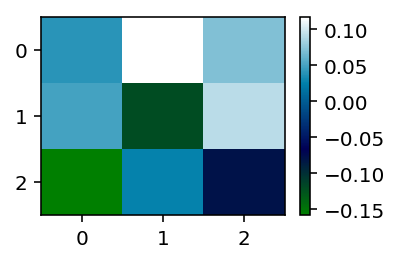

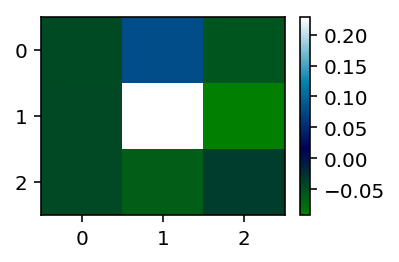

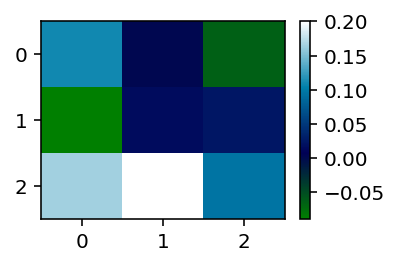

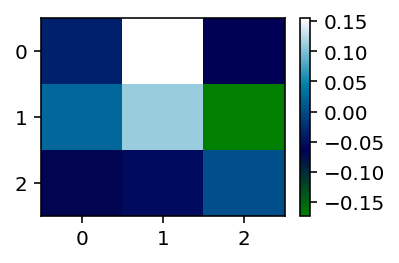

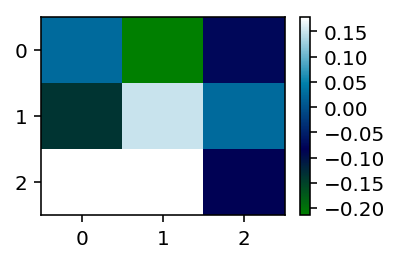

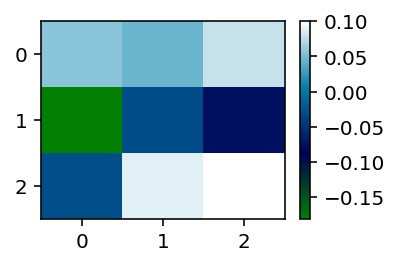

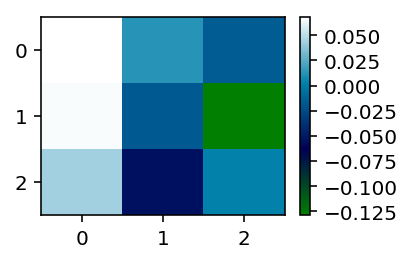

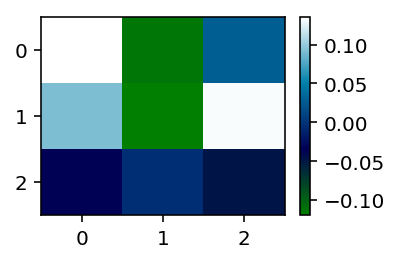

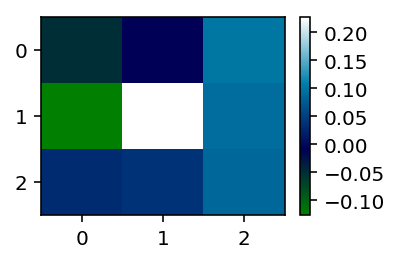

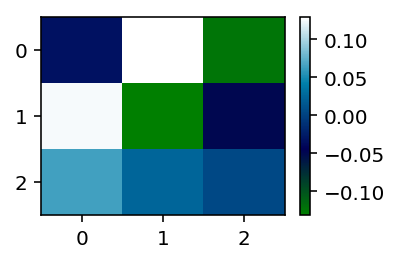

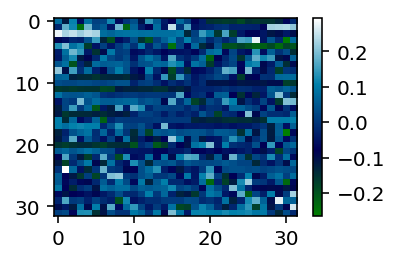

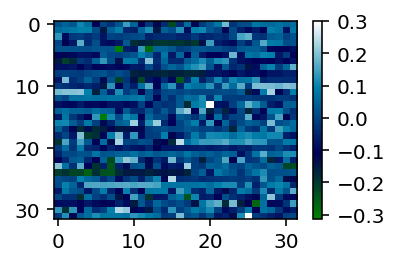

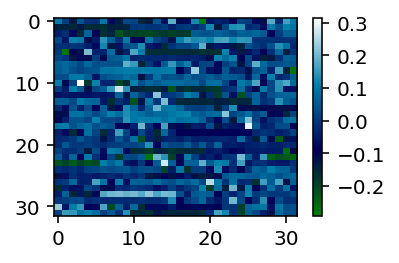

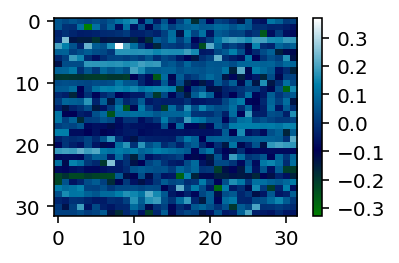

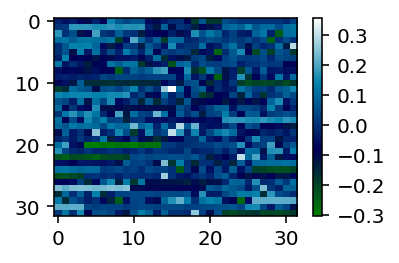

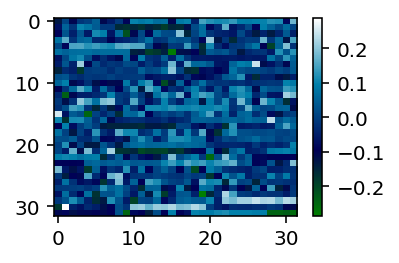

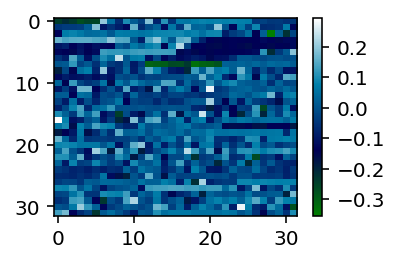

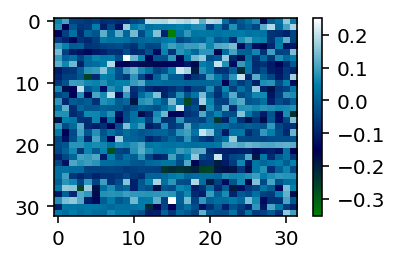

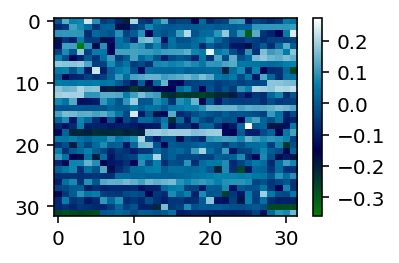

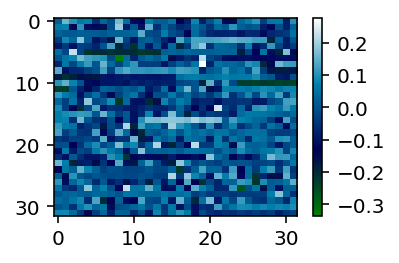

In [33]:
def show_weights(weights_id, weights_shape):
    mat = np.reshape(best_individ.gene[weights_id], weights_shape)

    for ii in range(10):
        acc_plot = plt.subplot(222)
        plt.imshow(mat[ii], interpolation='nearest', cmap=plt.cm.ocean, aspect='auto')
        plt.colorbar()
        plt.show()

show_weights(0, (-1, 3, 3))
show_weights(1, (-1, 3, 3))
show_weights(2, (-1, 32, 32))

In [34]:
best_individ.gene[2]

array([[ 0.08026167, -0.11652299,  0.11231424, ...,  0.12051531,
        -0.06082858,  0.00116121],
       [ 0.03785548, -0.10302757,  0.14225222, ...,  0.01766783,
        -0.06880809, -0.03528938],
       [-0.15008721, -0.1566126 , -0.16470268, ..., -0.15213883,
        -0.15312694, -0.12955494],
       ..., 
       [-0.01363564,  0.06703772, -0.01794718, ...,  0.03786286,
        -0.10554463,  0.06698056],
       [ 0.04575337,  0.06497502,  0.10656122, ..., -0.07559314,
        -0.04517339, -0.05205363],
       [ 0.01341324,  0.04415398, -0.00249794, ...,  0.03250653,
        -0.0367548 ,  0.05252856]], dtype=float32)

## Euclidean Distance Matrix

2


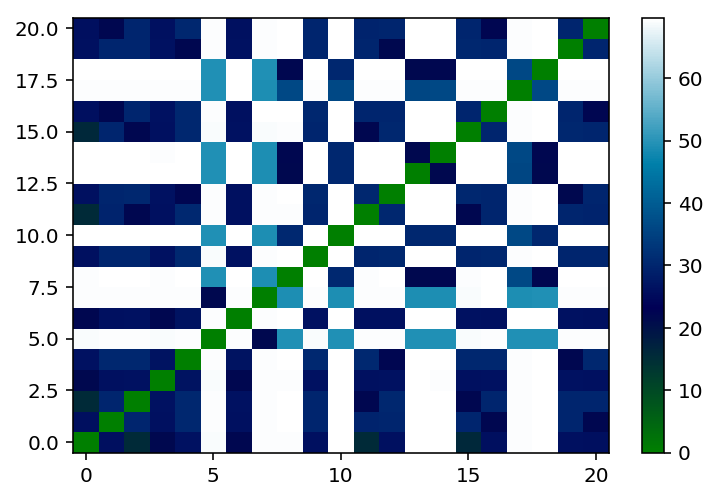

In [35]:
def compute_weights_distance(population, layer_id, layer_shape):
    population_size = len(population)
    distances = np.zeros((population_size, population_size), dtype=np.float32)

    print(layer_id)
    for ii, p in enumerate(population):
        for jj, q in enumerate(population):
            a = np.reshape(p.gene[layer_id], layer_shape)
            b = np.reshape(q.gene[layer_id], layer_shape)
            c = np.power(np.abs(a-b), 2)
            c = np.sum(c)
            c = np.sqrt(c)
            distances[ii, jj] = c

    plt.imshow(distances, interpolation='nearest', cmap=plt.cm.ocean, aspect='auto')
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.show()
    
compute_weights_distance(population.population, 2, (-1, 32, 32))